In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from random import randint
import scipy.stats as st
%matplotlib inline

In [21]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

In [25]:
def GetSeed(Image):
    Size=Image.shape
    cx=randint(2,Size[0]-2)
    cy=randint(2,Size[1]-2)
    Seed=Image[cx-1:cx+2,cy-1:cy+2]
    return(Seed*0.99)

def Image2Fill(SizeX,SizeY,Image):
    seed=GetSeed(Image)
    NewImage = np.empty([SizeX,SizeY])
    NewImage.fill(np.nan)
    NewImage[SizeX/2-1:SizeX/2+2,SizeY/2-1:SizeY/2+2]=seed
    return NewImage

def ComputeDistance(CurrentPatch,RefPatch,GKernel):
    Mask=~np.logical_and(~np.isnan(CurrentPatch),~np.isnan(RefPatch))
    RefPatch2=np.copy(RefPatch)
    CurrentPatch[Mask]=np.nan
    RefPatch2[Mask]=np.nan
    if (np.sum(~Mask*1)<2):
#         plt.imshow(RefPatch)
#         plt.show()
        return 100
    else:
        Dist=np.nansum(np.square(CurrentPatch-RefPatch)*GKernel)/np.sum(GKernel[~Mask])
        return Dist

def GetUnfilledNeigbors(NewImage):
    Size=np.array(NewImage.shape)
    Size[0]=Size[0]-2
    Size[1]=Size[1]-2
    Neighbors=np.zeros([Size[0]*Size[1],3],dtype=int)
    ind=0
    for i in range(1,Size[0]+1):
        for j in range(1,Size[1]+1):
            Neighbors[ind,1]=i
            Neighbors[ind,2]=j
            if ~np.isnan(NewImage[i,j]):
                Neighbors[ind,0]=-1
            else:
                Patch=NewImage[i-1:i+2,j-1:j+2]
                Patch[1,1]=np.nan
                Neighbors[ind,0]=np.sum(~np.isnan(Patch))
            ind=ind+1
    return Neighbors

def Distance(WindowSize,Image,NewImage,Sigma,Pixelx,Pixely):
    SizeNewImage=np.array(NewImage.shape)
    SizeImage=np.array(Image.shape)
    GKernel=gkern(WindowSize, Sigma)
    DistMat=np.ones_like(Image)*100
    
    RefPatch=np.empty([WindowSize,WindowSize])
    RefPatch.fill(np.nan)
    minxNew=np.max([0,Pixelx-WindowSize/2])
    minyNew=np.max([0,Pixely-WindowSize/2])
    maxxNew=np.min([SizeNewImage[0],Pixelx+WindowSize/2])
    maxyNew=np.min([SizeNewImage[1],Pixely+WindowSize/2])
    
    xmPatchRef=np.max([WindowSize/2-Pixelx,0])
    xMPatchRef=np.min([WindowSize,SizeNewImage[0] + WindowSize/2 - Pixelx])
    ymPatchRef=np.max([WindowSize/2-Pixely,0])
    yMPatchRef=np.min([WindowSize,SizeNewImage[1] + WindowSize/2 - Pixely])
    RefPatch[xmPatchRef:xMPatchRef,ymPatchRef:yMPatchRef]= NewImage[minxNew:maxxNew+1,minyNew:maxyNew+1]
    
    for i in range(WindowSize/2,SizeImage[0]+1-WindowSize/2):
        for j in range(WindowSize/2,SizeImage[1]+1-WindowSize/2):
            xmPatch=np.max([WindowSize/2-i,0])
            xMPatch=np.min([WindowSize,SizeImage[0] + WindowSize/2 - i])
            ymPatch=np.max([WindowSize/2-j,0])
            yMPatch=np.min([WindowSize,SizeImage[1] + WindowSize/2 - j])
            minx=i-WindowSize/2
            miny=j-WindowSize/2
            maxx=i+WindowSize/2
            maxy=j+WindowSize/2
            CurrentPatch=np.empty([WindowSize,WindowSize])
            CurrentPatch.fill(np.nan)
            CurrentPatch[xmPatch:xMPatch,ymPatch:yMPatch]=Image[minx:maxx+1,miny:maxy+1]
            dist=ComputeDistance(CurrentPatch,RefPatch,GKernel)
            DistMat[i][j]=dist
    return DistMat


def GrowTexture(WindowSize,SizeX,SizeY,Image):
    Threshold=0.1
    Sigma=WindowSize/6.4
    MaxErrorThresh=0.3
    
    NewImage=Image2Fill(SizeX,SizeY,Image)
    Neighbors=GetUnfilledNeigbors(NewImage)
    count=0
    while(sum((Neighbors[:,0]>0)*1)>0):
        progress=0
        posNei=np.argmax(Neighbors,0)[0]
        posNei=Neighbors[posNei,:]
        Pixelx=posNei[1]
        Pixely=posNei[2]
        Dist=Distance(WindowSize,Image,NewImage,Sigma,Pixelx,Pixely)
        indicesDist=np.array(np.where(Dist<=(np.min(Dist)*(1+Threshold))))
        randind=randint(0,len(indicesDist[0])-1)
        if Dist[indicesDist[0,randind],indicesDist[1,randind]] < MaxErrorThresh:
            IndiceImage=[indicesDist[0,randind],indicesDist[1,randind]]
            NewImage[Pixelx,Pixely]=Image[IndiceImage[0],IndiceImage[1]]
            progress=1
        if progress  == 0:
            MaxErrorThresh=MaxErrorThresh*1.1
        count=count+1
        Neighbors=GetUnfilledNeigbors(NewImage)
#         if (count%75==0):
#             plt.imshow(NewImage,cmap='gray')
#             plt.show()
    return NewImage[1:-1,1:-1]

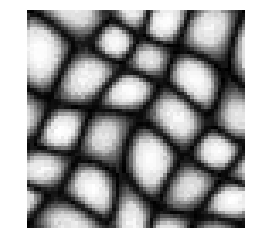

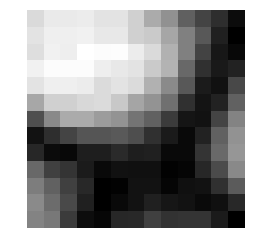

In [26]:
imgray=rgb2gray(np.array(mpimg.imread('../../161.gif')))/255.0
plt.imshow(imgray,cmap='gray')
plt.axis('off')
plt.show()
b=GrowTexture(7,15,15,imgray)
plt.imshow(b,cmap='gray')
plt.axis('off')
plt.show()